<a href="https://colab.research.google.com/github/mell00/gradcafe-stats/blob/main/gradstats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from datetime import datetime

def scrape_gradcafe_with_program_type(base_url="https://www.thegradcafe.com/survey/index.php", max_pages=2000):
    """
    Scrapes GradCafe, capturing:
      - Program (e.g. "Education Policy")
      - Program Type (e.g. "PhD", "Masters", etc.)
      - Decision (Accepted / Rejected / Waitlisted / Interview)
      - Decision Date (converted to standardized date)
      - GRE/GRE V/GRE AW/GPA
      - Nationality (American / International)
      - Season + Year (e.g. "Fall", "2025")
      - effective_year (custom logic based on Season, Year, and DecisionDate)
      - Date Posted (converted to standardized date if possible)
    """

    all_data = []

    for page_num in range(1, max_pages + 1):
        page_url = f"{base_url}?page={page_num}&sort=newest"
        print(f"\n====================================")
        print(f"Scraping page {page_num}: {page_url}")
        print(f"====================================\n")

        response = requests.get(page_url, timeout=10)
        if response.status_code != 200:
            print(f"[!] Skipping page {page_num}, status {response.status_code}")
            continue

        soup = BeautifulSoup(response.text, "html.parser")

        # The main table
        results_table = soup.select_one("table.tw-min-w-full.tw-divide-y.tw-divide-gray-300")
        if not results_table:
            print("[!] Could not locate main results table. Possibly no entries on this page.")
            continue

        rows = results_table.select("tbody tr")
        i = 0
        while i < len(rows):
            main_row = rows[i]
            tds = main_row.select("td")

            # at least 4 columns: School, Program, Date Posted, Decision
            if len(tds) < 4:
                i += 1
                continue

            # ========== Column 0 => School Name ==========
            school_div = tds[0].select_one("div.tw-font-medium.tw-text-gray-900.tw-text-sm")
            school = school_div.get_text(strip=True) if school_div else ""

            # ========== Column 1 => Program + Program Type ==========
            program_spans = tds[1].select("span")
            program_name = ""
            degree_type = ""
            if len(program_spans) >= 2:
                # e.g. <span>Education Policy</span><svg>...</svg><span>PhD</span>
                program_name = program_spans[0].get_text(strip=True)
                degree_type = program_spans[1].get_text(strip=True)
            else:
                # Fallback if HTML structure differs
                fallback_text = tds[1].get_text(strip=True)
                program_name = fallback_text

            # ========== Column 2 => Date Posted ==========
            date_posted_raw = tds[2].get_text(strip=True)
            # We'll standardize date posted (but typically do not need a default year)
            date_posted_std = standardize_date(date_posted_raw)

            # ========== Column 3 => Decision Text (like "Accepted on 24 Dec") ==========
            decision_div = tds[3].select_one("div")
            decision_text = decision_div.get_text(strip=True) if decision_div else ""
            decision_type = decision_text
            decision_date_raw = ""
            if " on " in decision_text:
                parts = decision_text.split(" on ", 1)
                decision_type = parts[0].strip()
                decision_date_raw = parts[1].strip()

            # ========== Next row(s) => tag row & comment row? ==========
            tag_row = None
            comment_row = None
            if i + 1 < len(rows) and "tw-border-none" in rows[i+1].get("class", []):
                tag_row = rows[i+1]
                if i + 2 < len(rows) and "tw-border-none" in rows[i+2].get("class", []):
                    comment_row = rows[i+2]
                    i += 3
                else:
                    i += 2
            else:
                i += 1

            # Gather tags from the tag row
            tags_text = []
            if tag_row:
                tag_tds = tag_row.select("td")
                if tag_tds:
                    tag_divs = tag_tds[0].select("div.tw-inline-flex")
                    for div in tag_divs:
                        tag_str = div.get_text(strip=True)
                        tags_text.append(tag_str)

            # ========== Parse GRE, GPA, Season, etc. from tags ==========
            gre_total, gre_v, gre_aw, gpa, nationality = parse_extra_tags(tags_text)
            season, year_str = parse_season_year(tags_text)  # e.g. "Fall", "2025"

            # ========== Convert Decision Date ==========
            # Convert the decision date into ISO format, guessing the year if needed
            decision_date_std = ""
            if decision_date_raw:
                try:
                    default_year = int(year_str) if year_str else None
                    decision_date_std = standardize_date(decision_date_raw, default_year)
                except Exception as e:
                    print(f"ERROR: Failed to standardize decision date '{decision_date_raw}' with year '{year_str}'. Error: {e}")

            # ========== Possibly parse out the comment row ==========
            comment_text = ""
            if comment_row:
                comment_tds = comment_row.select("td")
                if comment_tds:
                    c_div = comment_tds[0].select_one("p.tw-text-gray-500.tw-text-sm.tw-my-0")
                    if c_div:
                        comment_text = c_div.get_text(strip=True)

            # ========== Compute effective_year based on your custom logic ==========
            effective_year = ""
            if season and year_str and decision_date_std and decision_date_std != decision_date_raw:
                effective_year = compute_effective_year(season, year_str, decision_date_std)

                # ========== Replace the year in DecisionDate with effective_year ==========
                try:
                    dt = datetime.strptime(decision_date_std, '%Y-%m-%d')
                    # Attempt to replace the year
                    try:
                        dt_new = dt.replace(year=int(effective_year))
                        decision_date_std_new = dt_new.strftime('%Y-%m-%d')
                        decision_date_std = decision_date_std_new
                    except ValueError:
                        # Handle invalid dates, e.g., '2025-02-29' does not exist
                        if dt.month == 2 and dt.day == 29:
                            # Assign to 28 Feb of effective_year
                            dt_new = dt.replace(year=int(effective_year), day=28)
                            decision_date_std_new = dt_new.strftime('%Y-%m-%d')
                            decision_date_std = decision_date_std_new
                        else:
                            print(f"ERROR: Replacing year with 'effective_year' leads to invalid date. Keeping original DecisionDate='{decision_date_std}'")
                except Exception as e:
                    print(f"ERROR: Failed to parse DecisionDate '{decision_date_std}'. Error: {e}")
            else:
                print(f"WARNING: Missing or invalid data for effective year computation. Season='{season}', Year='{year_str}', DecisionDateISO='{decision_date_std}'")

            # ========== Build record ==========
            record = {
                "School":         school,
                "Program":        program_name,
                "Degree_Type":    degree_type,
                "Date_Posted":    date_posted_std,   # standardized date
                "Decision":       decision_type,
                "DecisionDate":   decision_date_std, # standardized date with effective_year
                "Season":         season,     # e.g. "Fall"
                "Year":           year_str,   # e.g. "2025"
                "effective_year": effective_year,
                "GRE_Total":      gre_total,
                "GRE_V":          gre_v,
                "GRE_AW":         gre_aw,
                "GPA":            gpa,
                "Nationality":    nationality,
                "Tags":           tags_text,   # optional debug
                "Comment":        comment_text
            }
            all_data.append(record)

    df = pd.DataFrame(all_data)
    return df



def parse_extra_tags(tags_list):
    """
    Example parser for GRE total, GRE V, GRE AW, GPA, American/International.
    """
    gre_total = ""
    gre_v = ""
    gre_aw = ""
    gpa = ""
    nationality = ""

    for tag in tags_list:
        lower = tag.lower()

        # GRE total, e.g. "GRE 324"
        mt = re.search(r'\bgre\D*(\d+(\.\d+)?)\b', lower)
        if mt:
            gre_total = mt.group(1)

        # GRE V, e.g. "GRE V 156"
        mv = re.search(r'\bgre\s+v\s+(\d+(\.\d+)?)\b', lower)
        if mv:
            gre_v = mv.group(1)

        # GRE AW, e.g. "GRE AW 4.50"
        maw = re.search(r'\bgre\s+aw\s+(\d+(\.\d+)?)\b', lower)
        if maw:
            gre_aw = maw.group(1)

        # GPA, e.g. "GPA 3.07"
        mgpa = re.search(r'\bgpa\s+(\d+(\.\d+)?)\b', lower)
        if mgpa:
            gpa = mgpa.group(1)

        # Nationality: "American" or "International"
        if "american" in lower:
            nationality = "American"
        elif "international" in lower:
            nationality = "International"

    return gre_total, gre_v, gre_aw, gpa, nationality


def parse_season_year(tags_list):
    """
    Looks for something like "Fall 2025" or "Spring 2024" in the tags.
    Returns (season, year) if found, else ("", "").
    """
    season_regex = re.compile(r'(Fall|Spring)\s+(\d{4})', re.IGNORECASE)
    season = ""
    year   = ""

    for tag in tags_list:
        match = season_regex.search(tag)
        if match:
            season = match.group(1).title()  # "Fall" or "Spring"
            year   = match.group(2)         # e.g. "2025"
            return season, year

    return season, year


from datetime import datetime


def standardize_date(date_str, default_year=None):
    """
    Converts date strings like "December 28, 2024" or "29 Feb"
    into ISO format (YYYY-MM-DD). If no year is provided,
    uses default_year if specified.

    Handles both "Month Day" and "Day Month" formats.
    Replaces "29 Feb" with "28 Feb" to avoid leap year issues.
    """
    date_str = date_str.strip().replace(",", "")  # Remove commas
    if not date_str:
        return ""

    # Replace "29 Feb" with "28 Feb"
    # Handle case-insensitive replacement
    if re.search(r'\b29\s+Feb\b', date_str, re.IGNORECASE):
        date_str = re.sub(r'\b29\s+Feb\b', '28 Feb', date_str, flags=re.IGNORECASE)

    # Expanded patterns to parse both 'Dec 23' and '23 Dec', etc.
    date_formats = [
        "%B %d %Y",  # e.g. "December 28 2024"
        "%b %d %Y",  # e.g. "Dec 28 2024"
        "%B %d",      # e.g. "December 28"
        "%b %d",      # e.g. "Dec 28"
        "%d %B %Y",   # e.g. "28 December 2024"
        "%d %b %Y",   # e.g. "28 Dec 2024"
        "%d %B",      # e.g. "28 December"
        "%d %b",      # e.g. "28 Dec"
    ]

    for fmt in date_formats:
        try:
            parsed = datetime.strptime(date_str, fmt)

            # If year is missing, assign default_year
            if parsed.year == 1900 and default_year:
                parsed = parsed.replace(year=default_year)

            standardized = parsed.strftime("%Y-%m-%d")
            return standardized
        except ValueError:
            continue  # Try the next format

    # If none of the formats worked, return empty string
    return ""






def compute_effective_year(season, year_str, decision_date_iso):
    """
    Custom logic to determine the 'effective_year' for the decision date,
    given the season/year (e.g. "Fall 2025") and the actual parsed date in ISO format (YYYY-MM-DD).

    Example rules might be:
    - If Season=Fall and month=12 => effective_year = season_year - 1
    - If Season=Spring and month in [6..11] => effective_year = season_year - 1
    - Otherwise => effective_year = season_year
    """
    try:
        dt = datetime.strptime(decision_date_iso, "%Y-%m-%d")
    except ValueError:
        # If we cannot parse => fallback
        return ""

    # Parse the season year into integer
    try:
        season_year = int(year_str)
    except (ValueError, TypeError):
        return ""

    month = dt.month

    # Default to the stated season year
    final_year = season_year

    season_lower = season.lower()

    # If Fall and decision is in December => final_year = season_year - 1
    if season_lower == "fall" and 11 <= month <= 12:
        final_year = season_year - 1

    # If Spring and decision is between June(6) and November(11) => final_year = season_year - 1
    elif season_lower == "spring" and 6 <= month <= 10:
        final_year = season_year - 1

    return str(final_year)


if __name__ == "__main__":
    # Example usage: scraping 2 pages (increase as needed).
    df_results = scrape_gradcafe_with_program_type(max_pages=1975)

    print("\n==================== FINAL DATAFRAME (first 30 rows) ====================")
    print(df_results.head(30))
    print(f"Total rows: {len(df_results)}")

    # Save to CSV:
    df_results.to_csv("gradcafe_with_program_and_effective_year.csv", index=False)
    print("\nSaved gradcafe_with_program_and_effective_year.csv.")



**R CODE**

[1] "Filtered Data Preview:"
# A tibble: 6 × 16
  School      Program Degree_Type Date_Posted Decision DecisionDate Season  Year
  <chr>       <chr>   <chr>       <date>      <chr>    <date>       <chr>  <dbl>
1 Rice Unive… Statis… PhD         2024-01-22  Accepted 2024-01-22   Fall    2024
2 Massachuse… Instit… PhD         2024-01-19  Intervi… 2024-01-19   Fall    2024
3 New York U… Data S… PhD         2024-01-09  Intervi… 2024-01-09   Fall    2024
4 Rice Unive… Statis… PhD         2024-01-03  Intervi… 2024-01-03   Fall    2024
5 Rice Unive… Statis… PhD         2023-12-27  Intervi… 2023-12-27   Fall    2024
6 Rice Unive… Statis… PhD         2023-12-19  Intervi… 2023-12-19   Fall    2024
# ℹ 8 more variables: effective_year <dbl>, GRE_Total <dbl>, GRE_V <dbl>,
#   GRE_AW <dbl>, GPA <dbl>, Nationality <chr>, Tags <chr>, Comment <chr>


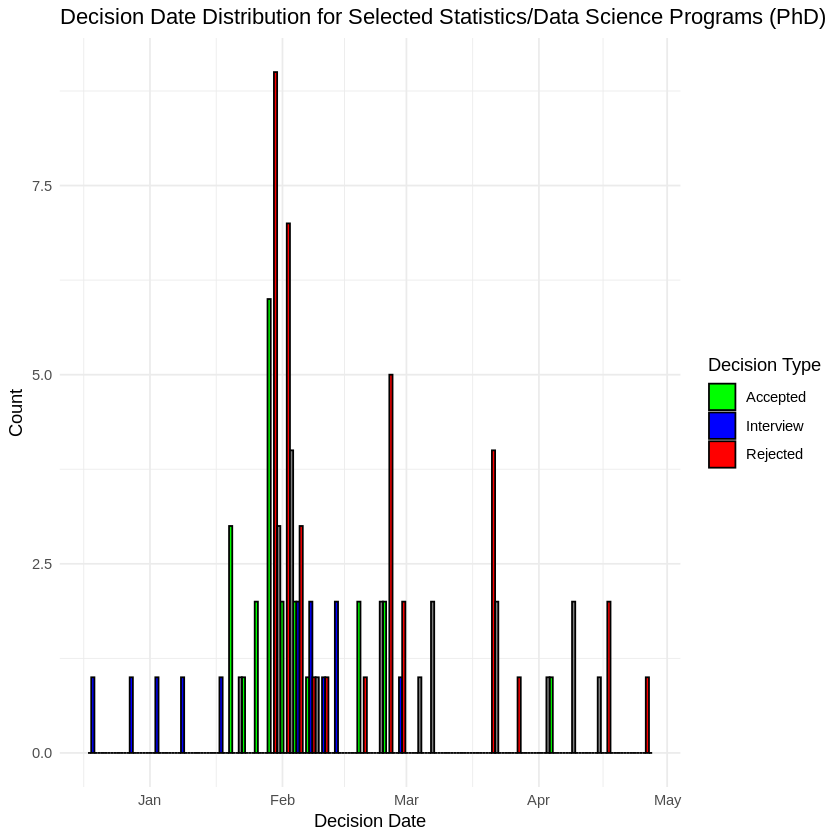

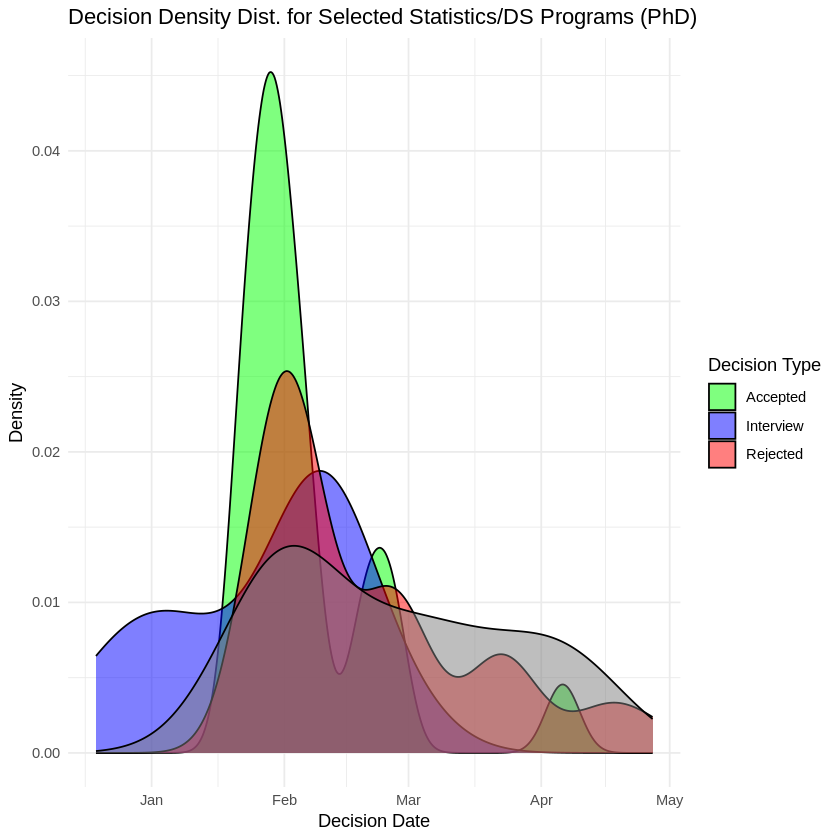

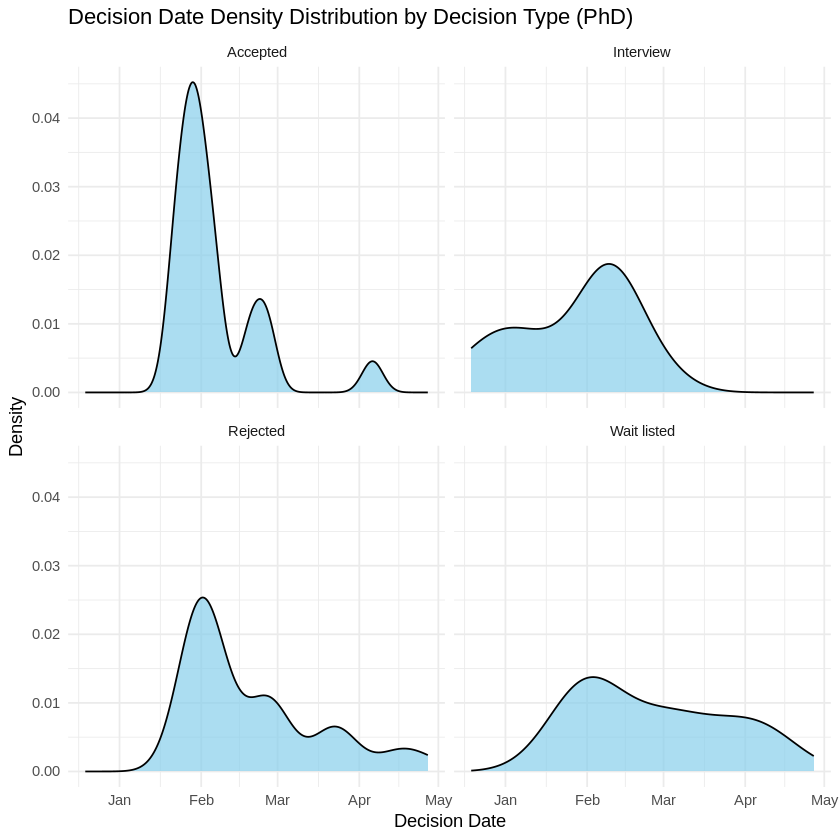

In [24]:

# Decision Date Distribution Analysis


library(tidyverse)
library(lubridate)


csv_file_path <- "gradcafe2024.csv"

#data <- read_csv(csv_file_path)

stats_university <- c("University of California-Los Angeles", "Texas A&M University - College Station (TAMU)",
"Cornell University", "University of California-Irvine", "Rice University", "University Of Washington", "Boston University")

statsci_university <- c("Duke University", "University of California-Santa Cruz")

datasci_university <- "New York University"

ses_university <- "Massachusetts Institute of Technology"

target_program <- c("Statistics", "Statistical Science", "Institute For Data, Systems And Society (IDSS)", "Social And Engineering Systems (SES)",
"IDSS", "Social And Engineering Systems (IDSS)", "IDSS SES", "Social And Engineering Systems", "SES", "Data Science")

university <- c(stats_university, statsci_university, datasci_university, ses_university)

timeframe <- c(2023,2024)

# ------------------------------
# Filter Data
# ------------------------------

filtered_data <- data %>%
  filter(
    School %in% university,
    Program %in% target_program,
    Degree_Type == "PhD",
    Season == "Fall",
    Year == 2024
  )


print("Filtered Data Preview:")
print(tail(filtered_data))

# ------------------------------
# 5. Analyze Data
# ------------------------------

# distribution of Decision Dates
ggplot(filtered_data, aes(x = DecisionDate, fill = Decision)) +
  geom_histogram(binwidth = 3, position = "dodge", color = "black") +
  scale_fill_manual(values = c("Accepted" = "green", "Rejected" = "red", "Waitlisted" = "orange", "Interview" = "blue")) +
  labs(
    title = "Decision Date Distribution for Selected Statistics/Data Science Programs (PhD)",
    x = "Decision Date",
    y = "Count",
    fill = "Decision Type"
  ) +
  theme_minimal()

ggplot(filtered_data, aes(x = DecisionDate, fill = Decision)) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c(
    "Accepted" = "green",
    "Rejected" = "red",
    "Waitlisted" = "orange",
    "Interview" = "blue"
  )) +
  labs(
    title = "Decision Density Dist. for Selected Statistics/DS Programs (PhD)",
    x = "Decision Date",
    y = "Density",
    fill = "Decision Type"
  ) +
  theme_minimal()

ggplot(filtered_data, aes(x = DecisionDate)) +
  geom_density(fill = "skyblue", alpha = 0.7) +
  facet_wrap(~ Decision) +
  labs(
    title = "Decision Date Density Distribution by Decision Type (PhD)",
    x = "Decision Date",
    y = "Density"
  ) +
  theme_minimal()



# write_csv(filtered_data, "filtered_gradcafe2024.csv")
